<img src="images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Quantum Advantage with Shallow Circuits

## Hidden Linear Function (HLF) Problem

Let us first define the problem that we are trying to solve.
An instance of the problem is specified by an integer $n$ and a symmetric matrix $A$ of size $n\times n$ such that $A$ has entries $0$ and $1$.
For example, one could choose $n=3$ and 

$$A=\left[ \begin{array}{ccc}
1 & 1 & 0  \\
1 & 0 & 1  \\
0 & 1 & 1  \\
\end{array} \right]$$

The HLF problem is defined in terms of a quadratic form

$$q(x)=\sum_{i,j=1}^n A_{i,j} x_i x_j {\pmod 4}$$

where $x=(x_1,x_2,\ldots,x_n)\in \{0,1\}^n$ is a vector of $n$ binary variables.
Here the sum is evaluated modulo four, that is, $q(x)$ takes values $0,1,2,3$. 

In our $3\times 3$ example 

$$q(x)=2x_1x_2 + 2x_2 x_3 + x_1^2 + x_3^2 {\pmod 4}$$

Note that $x_i^2=x_i$ since $x_i$ is a binary variable. Thus we can rewrite

$$q(x)=2x_1x_2 + 2x_2 x_3 + x_1 + x_3 {\pmod 4}$$

For example, $q(1,1,1)=2+2+1+1{\pmod 4}=2$.
We shall be interested in the case when $x$ lies in the binary null-space of $A$ defined as

$$\mathrm{Ker}(A)=\{ x\in \{0,1\}^n \, : \, Ax=0{\pmod 2} \}$$

Let's compute the null-space $\mathrm{Ker}(A)$ for our $3\times 3$ example. We have 

$$Ax = \left[ \begin{array}{ccc}
1 & 1 & 0  \\
1 & 0 & 1  \\
0 & 1 & 1  \\
\end{array} \right] \left[ \begin{array}{c} x_1 \\ x_2 \\ x_3 \\ \end{array} \right] 
=\left[ \begin{array}{c} x_1 + x_2 \\ x_1 +x_3 \\ x_2+ x_3 \\ \end{array} \right] $$

Thus $Ax=0{\pmod 2}$ is equivalent to $x_1+x_2 = 0 {\pmod 2}$, $x_1+x_3 = 0 {\pmod 2}$,
and $x_2+x_3 =0{\pmod 2}$. Since $x_i$ are binary variables, we have $x_1=x_2=x_3$. On other words,
the null-space contains only two vectors:

$$\mathrm{Ker}(A)=\{ (0,0,0), \quad (1,1,1)\}$$

Note that the restriction of $q(x)$ onto the null-space of $A$ is non-zero: $q(1,1,1)=2$.
It can be shown that, in general, the restriction of $q(x)$ onto the null-space of $A$ is a **linear function**. In other words, there exists a (generally not unique) vector $z\in \{0,1\}^n$ such that 

$$q(x)=2\sum_{i=1}^n z_i x_i {\pmod 4} \quad \mbox{for all $x\in \mathrm{Ker}(A)$}$$

**To summarize: a restriction of the quadratic form $q(x)$ onto the null-space of $A$ is always a linear function.
The HLF problem is to find such a linear function, i.e. to find a vector $z\in \{0,1\}^n$ as above.**

In our $3\times 3$ example the null-space of $A$ has only one non-zero vector $x=(1,1,1)$ and thus
$z=(z_1,z_2,z_3)$ is a solution of the HLF problem if

$$2=q(1,1,1)=2(z_1+z_2+z_3) {\pmod 4}$$

This is equivalent to 

$$z_1+z_2+z_3 = 1 {\pmod 2}$$

The problem has four solutions: $z=(1,0,0)$, $z=(0,1,0)$, $z=(0,0,1)$, and $z=(1,1,1)$.
Our goal is to find one solution (it does not matter which).


### 2D Hidden Linear Function Problem

We shall consider a special case of the HLF problem where each variable $x_i$ is associated with a
point in a two-dimensional grid. It is required that each quadratic term $x_i x_j$ that 
appears in the form $q(x)$ involves nearest-neighbor grid points $i,j$. 
In other words, $A_{i,j}=0$ unless
$i$ and $j$ are nearest neighbors.


It can be shown 
[[BGK17]](https://arxiv.org/abs/1704.00690)
that any classical algorithm that solves all instances of the 2D HLF problem with $n$ variables requires
a circuit of depth that grows logarithmically with $n$. In contrast, we will see that the problem can be
solved by a quantum circuit of a constant depth independent of $n$.

#### Graphical representation

An instance of the 2D HLF problem has a simple graphical representation. 
The off-diagonal part of $A$ can be considered as an adjacency matrix of a graph embedded into the 2D grid. The quadratic form $q(x)$ contains a term $x_i x_j$
for every edge $(i,j)$ of the graph. We shall indicate edges of the graph by green lines. 

Each diagonal element $A_{i,i}=1$ defines a "marked" grid point $i$.
The quadratic form $q(x)$ contains a linear term $x_i$ for each marked point $i$. 
We shall indicate marked grid points by red circles. 

In our $3\times 3$ example, the 
graphical representation of the quadratic form $q(x)$ would be as follows.

In [1]:
# graphical representation of the 3x3 example

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import numpy as np
from random import randint

# grid points associated with the variables
x1 = [0, 1]
x2 = [0, 0]
x3 = [1, 0]

# edge (x1,x2)
plt.plot( [x1[0] , x2[0]], [x1[1], x2[1]], 'g-', linewidth=6)
# edge (x2,x3)
plt.plot( [x2[0] , x3[0]], [x2[1], x3[1]], 'g-', linewidth=6)

# grid point x1
plt.plot(x1[0], x1[1], 'bo', markersize=14)
plt.plot(x1[0]+0.1, x1[1]-0.1, marker='$x_1$', color='black', markersize=30)
# grid point x2
plt.plot(x2[0], x2[1], 'bo', markersize=14)
plt.plot(x2[0]+0.1, x2[1]-0.1, marker='$x_2$', color='black', markersize=30)
# grid point x3
plt.plot(x3[0], x3[1], 'bo', markersize=14)
plt.plot(x3[0]+0.1, x3[1]-0.1, marker='$x_3$', color='black', markersize=30)

# mark grid point x1
plt.plot(x1[0], x1[1], 'ro', markersize=20)
# mark grid point x3
plt.plot(x3[0], x3[1], 'ro', markersize=20)


# remove bounding box
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
cur_axes.set_frame_on(False)

To make things more interesting, consider instances of the problem  with $n=20$ variables.
Such instances are defined on a grid of size $4\times 5$. 

Let us generate a random instance of such 2D HLF problem and plot the corresponding graph.
We select edges of the graph and marked grid points at random with specified probabilities. 

In [2]:
# This is auxiliary function that computes the null-space of a square binary matrix A modulo two
# Returns a binary matrix X such that columns of X span the null-space of A
def null2(A):
    n = A.shape[1]
    X = np.identity(n,dtype=np.int)

    # add one equation per time and properly update X
    for i in range(n):
        y = np.dot(A[i,:], X) % 2
        not_y = (y + 1) % 2
        good = X[:,np.nonzero(not_y)]
        good = good[:,0,:]
        bad = X[:, np.nonzero(y)]
        bad = bad[:,0,:]
        if bad.shape[1]>0 :
            bad = np.add(bad,  np.roll(bad, 1, axis=1) ) 
            bad = bad % 2
            bad = np.delete(bad, 0, axis=1)
            X = np.concatenate((good, bad), axis=1)
    return X

As a test, consider again the $3\times 3$ example

In [3]:
A = np.array([[1, 1, 0], [1, 0, 1], [0, 1 ,1]], np.int32)
print('A= \n',A)
# compute basis vectors of the null space
kerA = null2(A)
print('null space(A)=\n',kerA)

A= 
 [[1 1 0]
 [1 0 1]
 [0 1 1]]
null space(A)=
 [[1]
 [1]
 [1]]


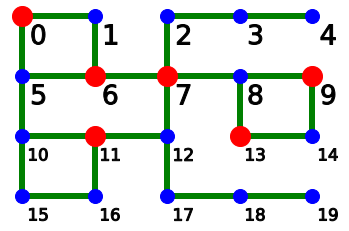

In [4]:
# generate random problem instance and its graphical representation

from random import randint
# dimensions of the grid
rows = 4
cols = 5
# number of variables
n = rows*cols

# random instance params:
# include every edge of the 2D grid with probability edge_prob
edge_prob = 0.66
# mark every grid point with probability point_prob
point_prob = 0.25

# define grid points
grid = []
for r in range(rows):
    for c in range(cols):
        grid.append([c,rows-r])
        
# generate an "interesting" instance of the 2D HLF problem
# We say that an instance is interesting if the null-space of A is non-empty
# and the restriction of q(x) onto the null-space of A is not identically zero

# repeat this until an interesting instance is found
while (True):
    # pick a random symmetric binary matrix A
    A = np.zeros([n,n])
    for i in range(n):
        for j in range(i+1,n):
            xi = grid[i]
            xj = grid[j]
            # check if xi and xj are nearest neighbors
            isNear = ( abs(xi[0]-xj[0]) + abs(xi[1]-xj[1]) == 1 )
            if isNear:
                # add an edge (xi,xj) with probability edge_prob
                A[i,j] =  int( np.random.uniform(0,1,1) < edge_prob) 
                A[j,i] = A[i,j]

    # mark each grid point with probability point_prob
    for i in range(n):
        A[i,i] =  int( np.random.uniform(0,1,1) < point_prob)


    # Compute the nullspace of A 
    null_space = null2(A)

    # dimension of the null-space 
    dim = null_space.shape[1]

    # compute q(x) for each basis vector of the null-space
    qform = np.zeros(dim, dtype = int)
    for i in range(dim):
        x=null_space[:,i]
        qform[i] = np.dot(x, np.dot(A,x)) % 4
        
    qform = qform.astype(int)


    # check if interesting instance is found
    if (dim>0) and (np.count_nonzero(qform)>0):
        break
    
# plot graph edges
for i in range(n):
        for j in range(i+1,n):
            xi = grid[i]
            xj = grid[j]
            if A[i,j]:
                plt.plot([xi[0],xj[0]], [xi[1],xj[1]], 'g-', linewidth=6)
                
# plot all grid points
for i in range(n):
    xi = grid[i]
    r = xi[0]
    c = xi[1]
    plt.plot(r, c, 'bo', markersize=14)
    plt.plot(r+0.2, c-0.3, marker='$%i$' %i, color='black', markersize=20)
    # check if xi is marked
    if A[i,i]:
        # mark this point
        plt.plot(r, c, 'ro', markersize=20)
    
# remove bounding box
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
cur_axes.set_frame_on(False)
    

In [5]:
print('Null-space of A has dimension ',dim)
print('The restriction of q(x) onto the null-space:')
for i in range(dim):
    print('Basis vector ', i,' : q(x) = ',qform[i])


Null-space of A has dimension  3
The restriction of q(x) onto the null-space:
Basis vector  0  : q(x) =  2
Basis vector  1  : q(x) =  2
Basis vector  2  : q(x) =  2


#### Quantum Algorithm

Let $E$ be the set of edges in the graph representing an instance of the 2D HLF problem (green lines).
Place a qubit at every grid point and consider the following quantum circuit

$$U=H^{\otimes n} \cdot \prod_{i \; \mathrm{marked}} \; S_i \cdot
\prod_{(i,j) \in E} \mathrm{CZ}_{i,j} \cdot H^{\otimes n}$$

Here $CZ$ gates are applied on edges (green lines) of the graph representing $q(x)$
and $S$ gates are applied to qubits located at marked grid points (red circles).

Apply the circuit $U$ to the initial state $|00\ldots 0\rangle$ and measure each qubit.
Let $z=(z_1,z_2,\ldots,z_n)\in \{0,1\}^n $ be the string of measurement outcomes.
It can be shown that $z$ is always a solution of the 2D HLF problem
[[BGK17]](https://arxiv.org/abs/1704.00690)


In [6]:
# implement the quantum circuit U defined above
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute

q = QuantumRegister(n, 'q')

c = ClassicalRegister(n)

circuit = QuantumCircuit(q)
measure = QuantumCircuit(q, c)
qc = QuantumCircuit(q, c)

circuit.h(q)
    
for i in range(n):
    for j in range(i+1,n):
        if A[i,j]:
            circuit.cz(q[i],q[j])

for i in range(n):
    if A[i,i]:
        circuit.s(q[i])

circuit.h(q)
    
measure.measure(q, c)
qc = circuit + measure

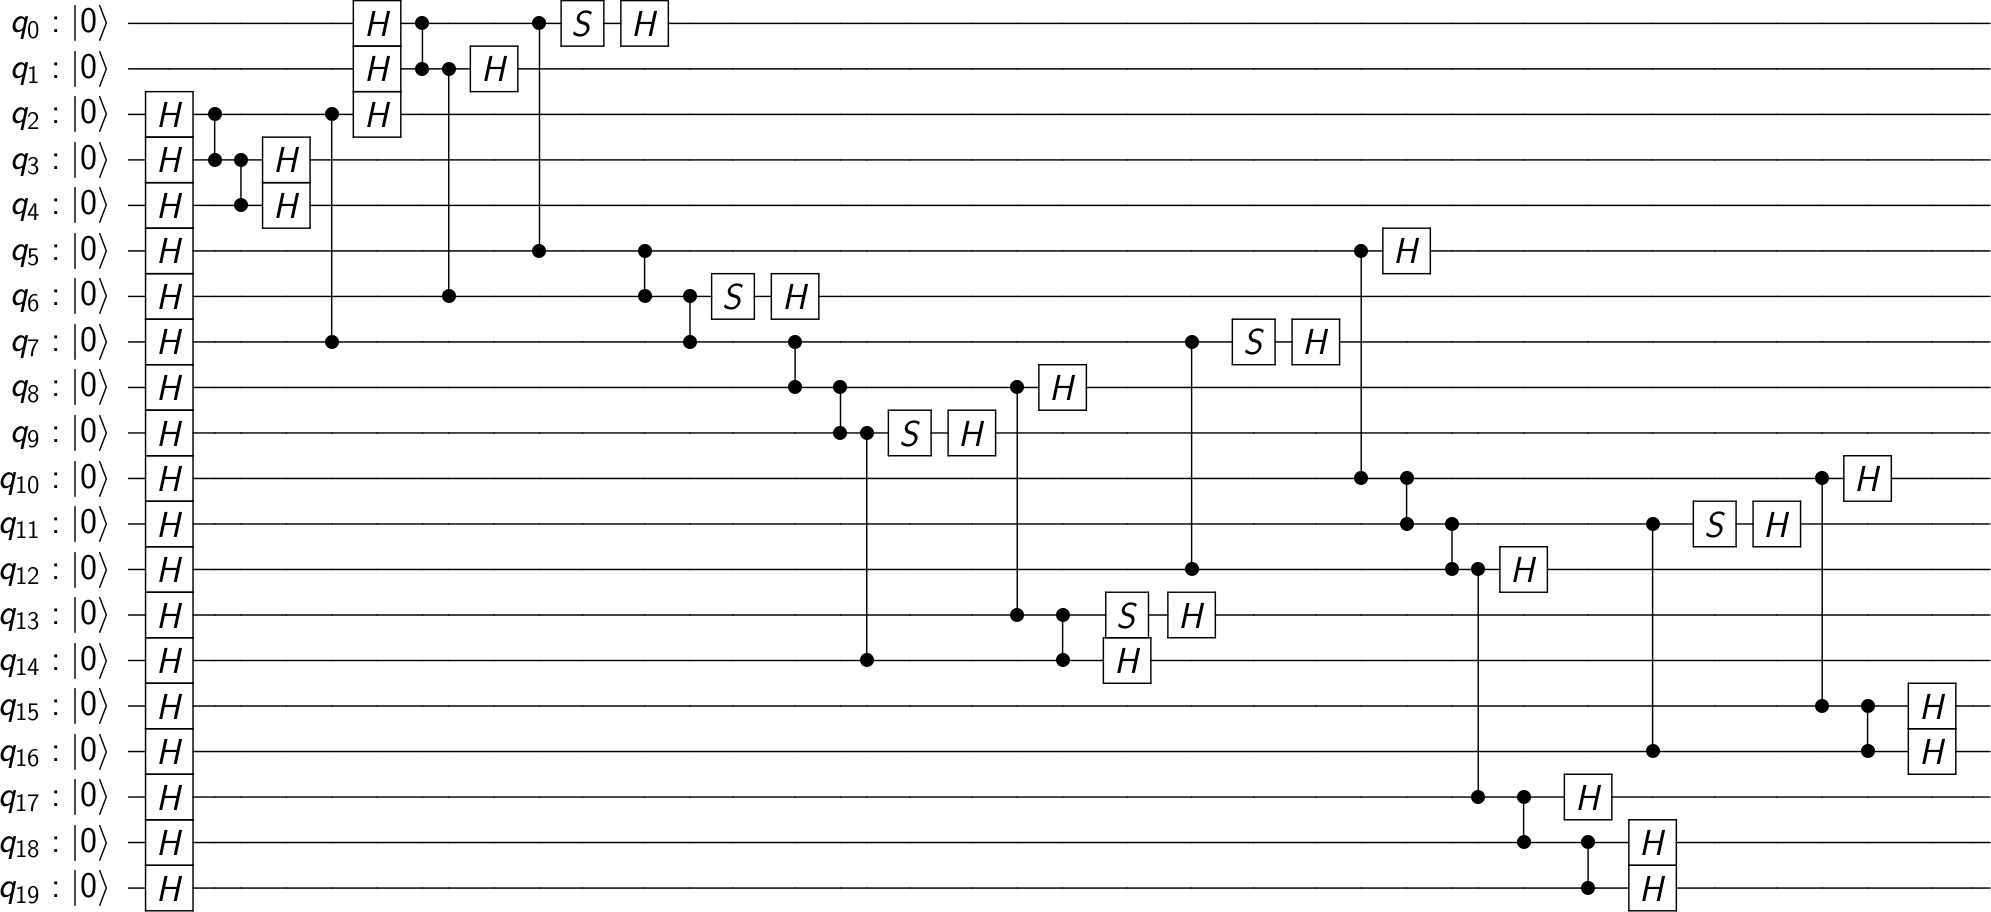

In [7]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(circuit, output="latex")

In [8]:
# simulate the circuit

num_shots = 10

from qiskit import Aer

backend = Aer.get_backend("qasm_simulator")
job_sim = execute(qc, backend, shots=num_shots)

sim_result = job_sim.result()

# tentative solution of the 2D HLF problem
x = sim_result.get_counts(qc)
print('quantum algorithm output:\n')
qout = np.empty([num_shots,n],dtype=int)
for i in range(num_shots):
    z = list(x)[i]
    z = np.array([int(d) for d in z], dtype=int)
    z = np.flip(z,0)
    print('shot',i,' :  z=',z)
    qout[i,:] = z

quantum algorithm output:

shot 0  :  z= [1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0]
shot 1  :  z= [0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0]
shot 2  :  z= [0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0]
shot 3  :  z= [1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 0 1 0]
shot 4  :  z= [1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0]
shot 5  :  z= [0 0 0 0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1]
shot 6  :  z= [1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1]
shot 7  :  z= [0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1]
shot 8  :  z= [0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1]
shot 9  :  z= [1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1]


#### Test the solution $z$ found by the quantum algorithm

For each basis vector x of the null-space $\mathrm{Ker}(A)$ check whether

$$q(x)=2\sum_{i=1}^n z_i x_i {\pmod 4} $$

In [9]:
print('Testing found solution of the HLF problem')
for shot in range(num_shots):
    z = qout[shot,:]
    qform_algorithm = np.zeros(dim)
    for i in range(dim):
        x=null_space[:,i]
        qform_algorithm[i] = 2*np.inner(z,x) % 4

    qform_algorithm = qform_algorithm.astype(int)

    outcome = np.array_equal(qform, qform_algorithm)
    if outcome:
        print('shot',shot,' : SUCCESS')
    else:
        print('shot',shot,' : FAILED')

Testing found solution of the HLF problem
shot 0  : SUCCESS
shot 1  : SUCCESS
shot 2  : SUCCESS
shot 3  : SUCCESS
shot 4  : SUCCESS
shot 5  : SUCCESS
shot 6  : SUCCESS
shot 7  : SUCCESS
shot 8  : SUCCESS
shot 9  : SUCCESS
